# Clustering

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import random
from functools import partial
import math

In [6]:
Point = complex

def X(point):
    return point.real

def Y(point):
    return point.imag

def distance(A, B):
    return abs(A - B)

def Data(num, seed=42):
    random.seed(seed * num)
    return [Point(random.random(), random.random()) for i in range(num)] 

def FileData(filename):
    with open(filename, "r") as f:
        data = []
        for line in f:
            coord = map(int, line.strip().split())
            data.append(Point(*coord))
        return data


In [7]:
def plot(dataset, s=3, c="k"):
    plt.scatter(map(X, dataset), map(Y, dataset), s=s, c=c)
    plt.axis('off')

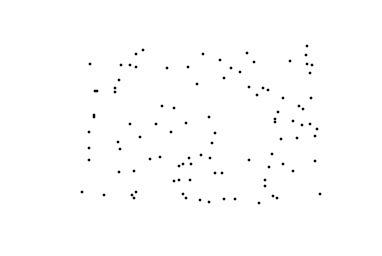

In [8]:
data = Data(100)
plot(data)

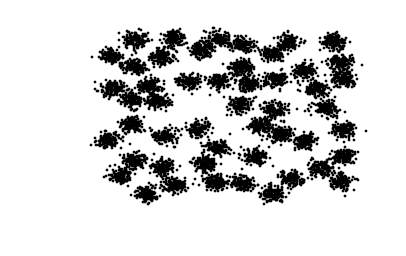

In [9]:
filedata = FileData("data.txt")
plot(filedata)

In [90]:
minX = min(map(X, filedata))
maxX = max(map(X, filedata))
minY = min(map(Y, filedata))
maxY = max(map(Y, filedata))

In [91]:
Sigmoid = complex
avg = lambda x: 0 if len(x) == 0 else sum(x)/len(x)

## K Means

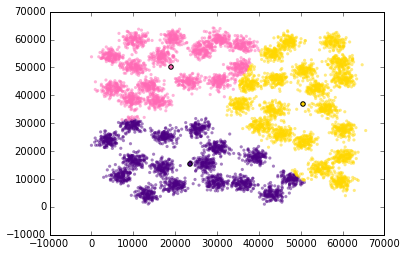

In [92]:
def k_means(data, sigmoids=None, num_clusters=3, iterations=10, seed=42):
    if not sigmoids:
        random.seed(seed * num_clusters)
        sigmoids = {Sigmoid(random.randrange(minX, maxX), random.randrange(minY, maxY)): [] for i in range(num_clusters)}
    for d in data:
        sig = min(((sig, distance(d, sig)) for sig in sigmoids.keys()), key=lambda t: t[1])
        sigmoids[sig[0]].append(d)
    if iterations > 1:
        new_sigmoids = {Sigmoid(X(avg(v)), Y(avg(v))): [] for v in sigmoids.values()}
        return k_means(data, sigmoids=new_sigmoids, num_clusters=num_clusters, iterations=iterations-1)
    return sigmoids

def plot_clusters(clusters):
    cols = iter(matplotlib.colors.cnames)
    for sig, data in clusters.items():
        c = cols.next()
        plt.scatter(map(X, data), map(Y, data), s=10, c=c, alpha=0.5, edgecolor='none')
        plt.scatter([X(sig)], [Y(sig)], s=20, c=c)

plot_clusters(k_means(filedata))

Lets try with initialising more clusters

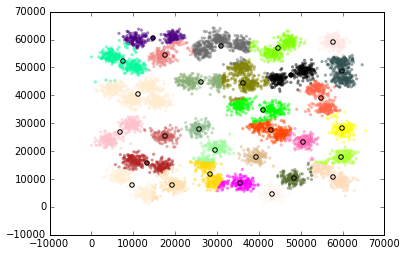

In [79]:
plot_clusters(k_means(filedata, num_clusters=30))

The problem with this us that we don't know how many clusters there are, and the initialization of sigmoids are random. Lets try with some other randomly initialized sigmoids.

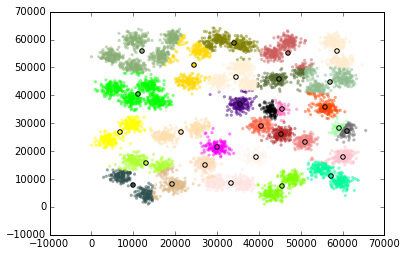

In [35]:
plot_clusters(k_means(filedata, num_clusters=30, seed=1337))

This give a complete different answer, but the number of sigmoids are still way off.

We can iterate different number of clusters, and then pick the best one. For this, we'll need an evaluation function. Lets use *Sum of Squared Errors*.

In [58]:
def SSE(sigmoid, points):
    return sum(distance(sigmoid, p) for p in points)

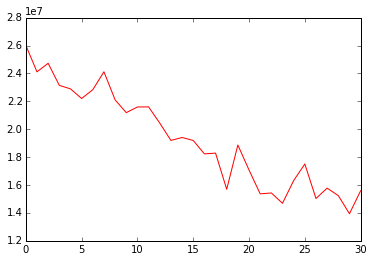

In [85]:
def iter_k_means(min_c=1, max_c=30, seed=8):
    new_seed = seed * max_c * min_c
    results = []
    for i in range(min_c, max_c+1):
        clusters = k_means(filedata, num_clusters=i, seed=new_seed)
        cluster_SSE = [SSE(s, ps) for s, ps in clusters.items()]
        results.append(sum(cluster_SSE))
    return results

def iter_k_means_plot():
    rng = (30, 60)
    result = iter_k_means(*rng)
    plt.plot(result)

iter_k_means_plot()

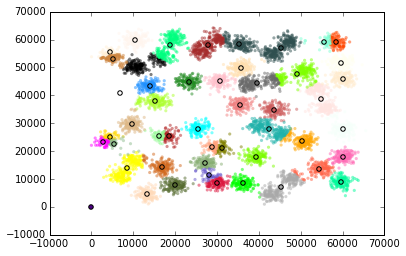

In [89]:
plot_clusters(k_means(filedata, num_clusters=50, seed=20))

## Hierarchical Clustering

We don't need to guess the number of clusters in hierarchical clustering. This is a great advantage.